In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import experimental, Conv2D, MaxPooling2D, Dense, Flatten
import matplotlib.pyplot as plt

In [21]:
IMAGE_SIZE=256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 25

In [22]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("../leaves/images/",
                                                    shuffle=True,
                                                    image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                    batch_size=32)

Found 7221 files belonging to 8 classes.


In [23]:
class_names = dataset.class_names

In [24]:
len(dataset) #Is a batch of 32 images so its all the picture / by batch

226

(32, 256, 256, 3)


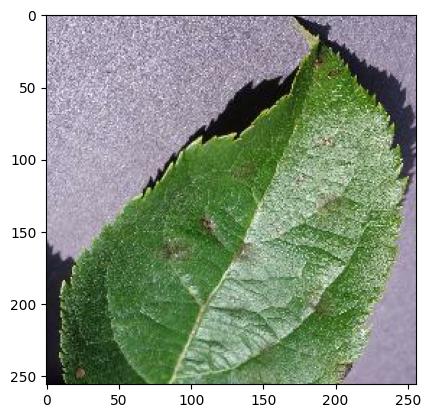

In [25]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    print(image_batch.shape) #size of batch, size image, nb of color(rgb)

In [56]:
# 80% to training
# After each epoch 10% will be usr to verify how close are we for the good value
# Last 10% to test
def get_dataset_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    if (shuffle):
        ds = ds.shuffle(shuffle_size, seed=12)
    training_set = dataset.take(int(len(dataset) * 0.8))
    left_df = dataset.skip(int(len(dataset) * 0.8)) # Skip the first 80%
    print(len(left_df))
    validation_set = left_df.take(int(len(left_df) * 0.5)) #take half of the remaining
    print(len(validation_set))
    test_set = left_df.skip(int(len(left_df) * 0.5)) #take half of the remaining

    return training_set,validation_set,test_set

In [57]:
training_set, validation_set, test_set = get_dataset_partitions(dataset)

46
23


In [58]:
print(len(test_set))
print(len(validation_set))
print(len(training_set))

23
23
180


In [62]:
training_set = training_set.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = Sequential([
    experimental.preprocessing.Resizing(IMAGE_SIZE/IMAGE_SIZE)
    experimental.preprocessing.Rescaling(1.0/255)
])
